<a href="https://colab.research.google.com/github/aulphin/S-GuISE/blob/main/Tutorial_Image_Classification_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#%cd /content/drive/MyDrive/Colab Notebooks/New-Project/PASCAL-DATASET/JPEGImages

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/New-Project/LIME/lime-master/doc/notebooks

/content/drive/MyDrive/Colab Notebooks/New-Project/LIME/lime-master/doc/notebooks


Here is a simpler example of the use of LIME for image classification by using Keras (v2 or greater)

In [ ]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.15.0


# Using Inception
Here we create a standard InceptionV3 pretrained model and use it on images by first preprocessing them with the preprocessing tools

In [ ]:
inet_model = inc_net.InceptionV3()

In [ ]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))  # 299, 299
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

## Let's see the top 5 prediction for some image

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/New-Project/PASCAL-DATASET

/content/drive/MyDrive/Colab Notebooks/New-Project/PASCAL-DATASET


In [ ]:
#%cd /content/drive/MyDrive/Colab Notebooks

In [ ]:
images = transform_img_fn([os.path.join('JPEGImages','000236.jpg')])

In [ ]:
#images = transform_img_fn([os.path.join('New-Project','eglu.jpg')])

1/1 [==============================] - 2s 2s/step
('n01560419', 'bulbul', 0.62027615)
('n01828970', 'bee_eater', 0.07262044)
('n01537544', 'indigo_bunting', 0.032498628)
('n01843065', 'jacamar', 0.025355158)
('n01824575', 'coucal', 0.02336359)


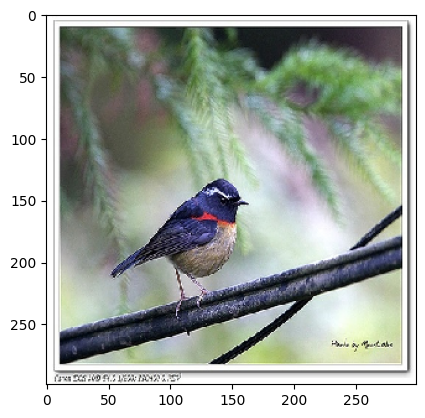

In [ ]:

# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

## Explanation
Now let's get an explanation

In [ ]:
#%cd /content/drive/MyDrive/Colab Notebooks/New-Project/LIME/lime-master/lime

In [ ]:
!pip install lime

In [ ]:
from lime import lime_image

In [ ]:
# %load_ext autoreload
# %autoreload 2
# import os,sys
# try:
#     import lime
# except:
#     sys.path.append(os.path.join('..', '..')) # add the current directory
#     import lime
# from lime import lime_image

In [ ]:
explainer = lime_image.LimeImageExplainer()

hide_color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels. Here, we set it to 0 (in the representation used by inception model, 0 means gray)

In [ ]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step
CPU times: user 22.3 s, sys: 383 ms, total: 22.7 s
Wall time: 34.2 s


Image classifiers are a bit slow. Notice that an explanation on my Surface Book dGPU took 1min 12s

### Now let's see the explanation for the top class

We can see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

In [ ]:
from skimage.segmentation import mark_boundaries

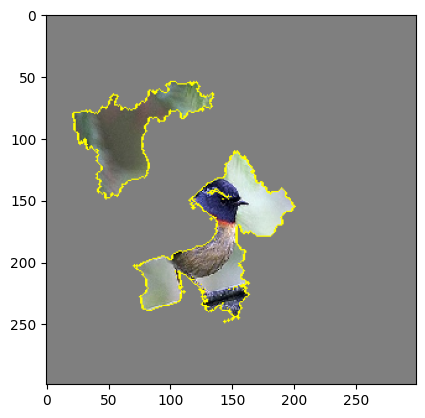

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or with the rest of the image present:

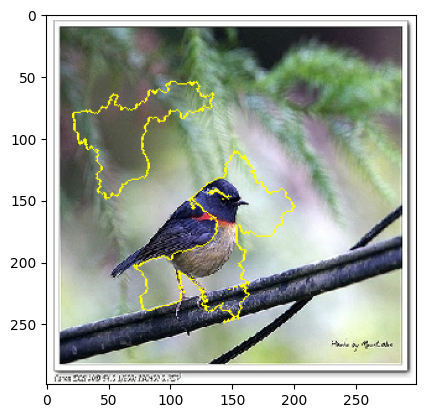

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


We can also see the 'pros and cons' (pros in green, cons in red)

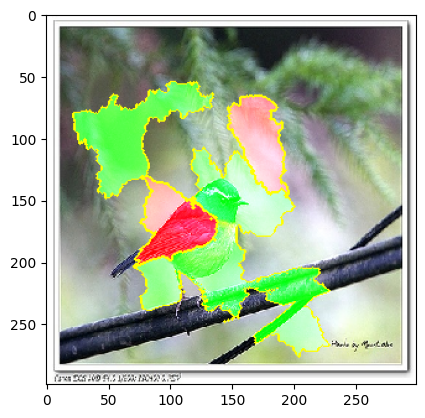

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

############################### upto this ######################################

Or the pros and cons that have weight at least 0.1

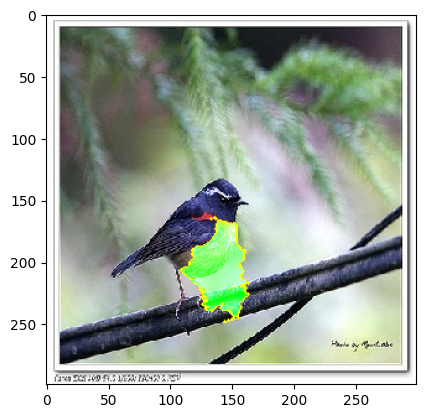

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Alternatively, we can also plot explanation weights onto a heatmap visualization. The colorbar shows the values of the weights.

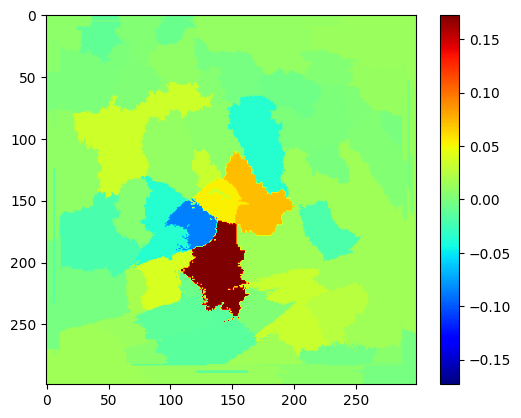

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'jet', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

### Let's see the explanation for the second highest prediction

Most positive towards wombat:

In [ ]:
# temp, mask = explanation.get_image_and_mask(21, positive_only=True, num_features=5, hide_rest=True)
# plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Pros and cons:

In [ ]:
# temp, mask = explanation.get_image_and_mask(82, positive_only=False, num_features=10, hide_rest=False) #106
# plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


Experiment for saliency map

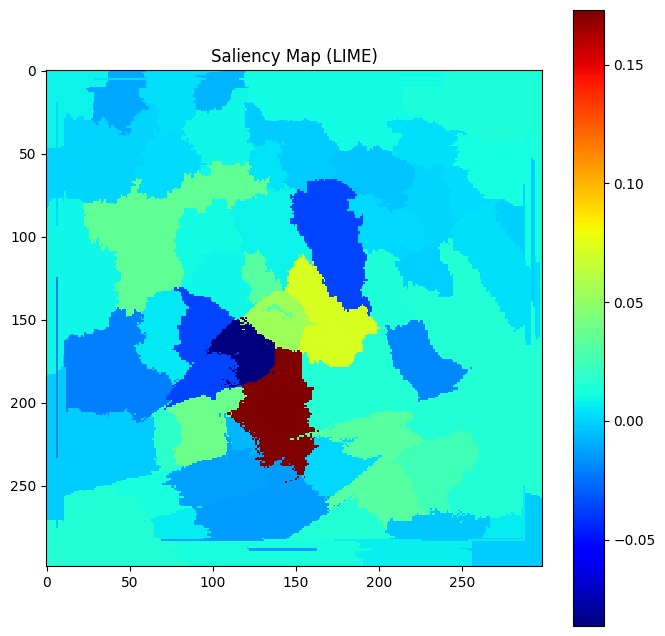

In [ ]:
# Visualize saliency map
plt.figure(figsize=(8, 8))
plt.imshow(heatmap, cmap='jet', interpolation='nearest')
plt.colorbar()
plt.title('Saliency Map (LIME)')
plt.show()

